# Customer Retention Analysis: Telco Churn Dataset
### Understanding customer behavior and identifying churn drivers for a telecommunications company

---

## Notebook 04: Modeling

This notebook develops, evaluates, and compares several machine learning models to predict customer churn. Building on the cleaned and feature-engineered dataset from the previous notebooks, we create end-to-end modeling pipelines that include preprocessing, transformation, and model training steps.

We train and assess multiple baseline models - including Logistic Regression, Random Forest, and Gradient Boosting - using stratified cross-validation to ensure robust evaluation across imbalanced churn classes. Performance is measured using ROC AUC and Precision-Recall AUC, metrics well-suited for churn prediction tasks where correctly identifying churners is more important than overall accuracy.

This notebook concludes with a comparison of model performance, identifies the strongest baseline candidate, delves into threshold optimization, and interpreting modeling results using the SHAP framework.

---

## Modeling: Table of Contents

- [4.0 Build Model Pipelines & Train Models](#40-build-model-pipelines--train-models)
    - [4.0.1 Define Feature Groups](#401-define-feature-groups)
    - [4.0.2 Train Models](#402-train-models)
    - [4.0.3 Cross-Validation Framework](#403-cross-validation-framework)
- [4.1 Model Performance Comparison](#41-model-performance-comparison)
- [4.2 Threshold Optimization](#42-threshold-optimization)
    - [4.2.1 Model Interpretability with SHAP](#421-model-interpretability-with-shap)
- [4.3 Modeling Summary](#43-model_summary)

#### Import Libaraies & Modules

In [3]:
# Setup path
from setup_paths import add_project_root
add_project_root()

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold
import shap

# Modeling modules
from src.models.model_configs import models
from src.models.trainer import train_model
from src.preprocessing import build_preprocessor
from src.features import get_numeric_features, get_categorical_features, get_model_features, get_target, get_eda_only_features
from src.plot_style import TITLE_FONT_SIZE, TITLE_FONT_WEIGHT

### Load Prepared Data
Load the clearned dataset from Notebook 02.

In [5]:
# Load the cleaned Telco Churn Dataset
df = pd.read_csv('../data/cleaned/telco_churn_clean.csv', index_col='customer_id')

df.head() # Inspect data

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,avg_monthly_charges,revenue_per_year,has_streaming,has_internet,num_services,paperless_and_monthly,automatic_payments,total_charges_per_service,monthly_charges_per_service,loyal_high_spender
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,29.850000,358.200000,No,Yes,2,Yes,No,9.95,9.95,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,55.573529,666.882353,No,Yes,4,No,No,377.90,11.39,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,54.075000,648.900000,No,Yes,4,No,No,21.63,10.77,No
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,40.905556,490.866667,No,Yes,4,No,Yes,368.15,8.46,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,75.825000,909.900000,No,Yes,2,Yes,No,50.55,23.57,No


 ## 4.0 Build Model Pipelines & Train Models <a class="anchor" id="40-build-model-pipelines--train-models"></a>

This section defines the preprocessing pipeline used in all models.
Numerical features are imputed with the median and scaled; categorical features are imputed and one-hot encoded.
We use ColumnTransformer so that preprocessing is included directly inside the modeling pipeline.


In [6]:
# List all models defined in src/models/model_configs.py
models_to_try = list(models.keys())
for model in models_to_try:
    print(model)

logistic_regression
random_forest
gradient_boosting


### 4.0.1 Define Feature Groups <a class="anchor" id="401-define-feature-groups"></a>
Store numerical and categorical features for preprocessing pipelines.

In [7]:
# Get features 
eda_only_features = get_eda_only_features()
categorical_features = get_categorical_features(df=df)
numeric_features = get_numeric_features(df=df)
feature_cols = get_model_features(df=df)
target_col = get_target(df=df)

# Filter out EDA-only features and target (churn)
categorical_features = [col for col in categorical_features if col not in eda_only_features + target_col]
numeric_features = [col for col in numeric_features if col not in eda_only_features + target_col]


### 4.0.2 Train Models <a class="anchor" id="402-train-models"></a>

We construct three baseline models - Logistic Regression, Random Forest, and Gradient Boosting - and wrap each in a unified pipeline that includes preprocessing.
Using identical preprocessing prevents data leakage and ensures fair model comparison.

In [8]:
# Get trained models 
trained_models = {}

for m in models_to_try:
    print(f'\nTraining model: {m}...')
    
    model, splits = train_model(
        model_name=m,
        df=df,
        feature_cols=feature_cols,
        target_col=target_col,
        categorical_features=categorical_features,
        numeric_features=numeric_features,
        tune=False  # Set to True to enable GridSearchCV
    )

    trained_models[m] = (model, splits)

print('\nAll models trained.')

# Unpack splits
X_train, X_test, y_train, y_test = splits

# Convert target values to binary
mapping_dict = {'No': 0, 'Yes': 1}
map_func = np.vectorize(lambda x: mapping_dict[x])
y_train = map_func(y_train)
y_test  = map_func(y_test)


Training model: logistic_regression...

Training model: random_forest...

Training model: gradient_boosting...

All models trained.


### 4.0.3 Cross-Validation Framework <a class="anchor" id="403-cross-validation-framework"></a>

We evaluate each model using 5-fold stratified cross-validation.
Performance is measured using Receiver Operator Characteristic Area Under the Curve (ROC-AUC) and Precision-Recall Area Under the Curve (PR-AUC), which are appropriate for imbalanced churn prediction.

In [9]:
# Get preprocessor
preprocessor = build_preprocessor(
    numeric_features=numeric_features,
    categorical_features=categorical_features
)

full_rows = [] # CV model scores for plotting
summary_rows = [] # Summary statistics DataFrame rows

# 5-fold, stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Iterate over models, store cross-validation scores
for name, base_clf in models.items():
    
    # Setup pipeline using preprocessor
    clf_pipe = Pipeline(steps=[('prep', preprocessor), ('model', base_clf)])

    # Store cross-validation scores
    cv_scores = cross_validate(
        clf_pipe, X_train, y_train,
        cv=cv,
        scoring=['roc_auc', 'average_precision'],
        n_jobs=-1,
    )

    # Store raw scores for plotting
    for i in range(len(cv_scores['test_roc_auc'])):
        full_rows.append({
            'model': name,
            'fold': i + 1,
            'ROC AUC': cv_scores['test_roc_auc'][i],
            'PR AUC': cv_scores['test_average_precision'][i]
        })

    # Get score summary statistics by model for performance comparison
    summary_rows.append({
        'model': name,
        'cv_roc_auc_mean': cv_scores['test_roc_auc'].mean(),
        'cv_pr_auc_mean': cv_scores['test_average_precision'].mean(),
        'cv_roc_auc_std': cv_scores['test_roc_auc'].std(),
        'cv_pr_auc_std': cv_scores['test_average_precision'].std(),
    })


## 4.1 Model Performance Comparison <a class="anchor" id="41-model-performance-comparison"></a>

To understand how much modeling choice matters beyond preprocessing, we compare a few common classifiers using the same preprocessing pipeline:

- Logistic Regression (with class weights)
- Random Forest
- Gradient Boosting

We evaluate each with stratified 5‑fold cross‑validation using ROC‑AUC and PR‑AUC.


In [10]:
# Create model comparison DataFrame
model_compare_df = pd.DataFrame(summary_rows).sort_values('cv_pr_auc_mean', ascending=False)
model_compare_df.reset_index(drop=True, inplace=True)
model_compare_df # Display scores

,model,cv_roc_auc_mean,cv_pr_auc_mean,cv_roc_auc_std,cv_pr_auc_std
0,logistic_regression,0.845945,0.661697,0.012866,0.033068
1,gradient_boosting,0.842731,0.657539,0.008718,0.015776
2,random_forest,0.825708,0.621708,0.005423,0.012346


In [11]:
# Set style & theme for data visualizations
sns.set_theme(style='whitegrid', context='notebook', palette='colorblind')

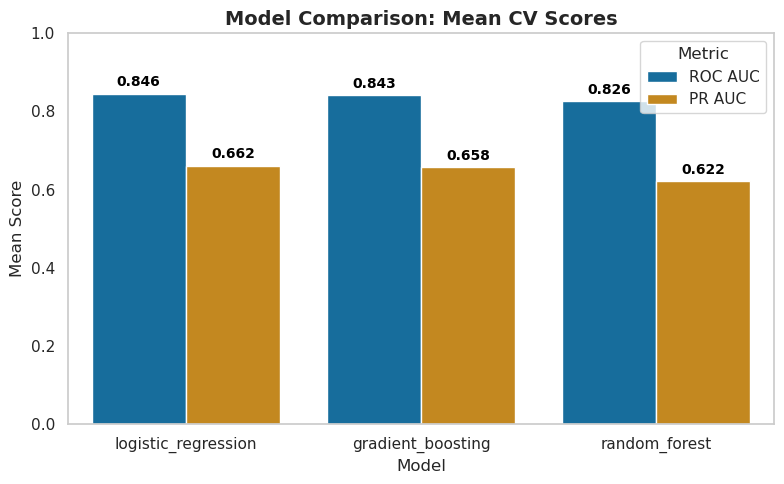

In [12]:
# Melt dataframe to long format for plotting
df_plot = model_compare_df.melt(
    id_vars='model',
    value_vars=['cv_roc_auc_mean','cv_pr_auc_mean'],
    var_name='metric',
    value_name='score'
)

# Map metric names to something cleaner
df_plot['metric'] = df_plot['metric'].map({
    'cv_roc_auc_mean': 'ROC AUC',
    'cv_pr_auc_mean': 'PR AUC'
})

# Set style
plt.figure(figsize=(8,5))

# Bar plot
bar_plot = sns.barplot(data=df_plot, x='model', y='score', hue='metric')

# Add annotations
for p in bar_plot.patches[:6]:
    height = p.get_height()
    bar_plot.annotate(f'{height:.3f}',
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='bottom',
                      fontsize=10,
                      fontweight=TITLE_FONT_WEIGHT,
                      color='black',
                      xytext=(0, 3),
                      textcoords='offset points'
                      )

# Labels and title
plt.title('Model Comparison: Mean CV Scores', fontsize=TITLE_FONT_SIZE, fontweight=TITLE_FONT_WEIGHT)
plt.grid(False)
plt.ylabel('Mean Score', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Model', fontsize=12)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


**Observations:** The bar plot above visualizes the mean cross-validation scores for each baseline model across two key metrics: ROC-AUC and PR-AUC.

ROC-AUC measures the model’s ability to distinguish between churners and non-churners across all thresholds, while PR-AUC emphasizes performance on the minority class (churners), which is particularly important for imbalanced datasets.

Annotations above each bar indicate the exact mean score, making it easy to identify the top-performing model at a glance. This visual comparison complements the numerical summary table, highlighting both performance and relative differences between models.

In [13]:
# Select best performing model
best_model_name = 'logistic_regression'
best_model = Pipeline(steps=[('prep', preprocessor), ('model', models[best_model_name])])
best_model_title = best_model_name.replace('_', ' ').title() # Title format for plots

# Fit on full training data
best_model.fit(X_train, y_train)

# Predict probabilities for positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

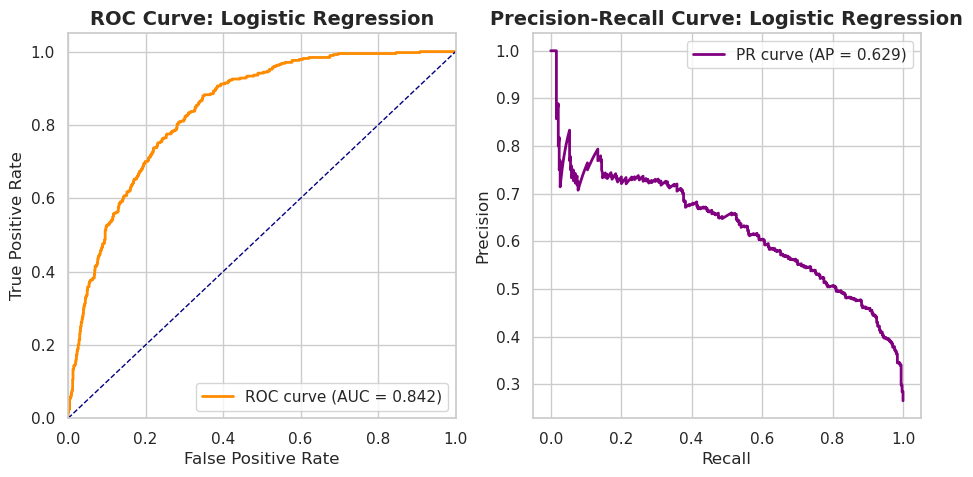

In [14]:
# ROC and PR plot figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Get ROC-AUC 
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs, pos_label=1) 
roc_auc = auc(fpr, tpr)

# Get PR curve and score
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs, pos_label=1)
pr_auc = average_precision_score(y_test, y_probs)

# Plot ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Baseline diagonal
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title(f'ROC Curve: {best_model_title}', fontsize=TITLE_FONT_SIZE, fontweight=TITLE_FONT_WEIGHT)
axes[0].legend(loc='lower right')
axes[0].grid(True)

# Plot Precision-Recall Curve
axes[1].plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve: {best_model_title}', fontsize=TITLE_FONT_SIZE, fontweight=TITLE_FONT_WEIGHT)
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.show()


**Observations:** To further evaluate the predictive performance of the selected baseline model, we examine its ROC curve and Precision-Recall (PR) curve on the held-out test set.

The ROC curve illustrates how well the model separates churners from non-churners across all possible decision thresholds by plotting the True Positive Rate against the False Positive Rate. The corresponding AUC (Area Under the Curve) provides a threshold-independent measure of overall discriminative ability.

Because churn prediction is an imbalanced classification problem, the PR curve offers an equally important perspective. It highlights the trade-off between precision (How many predicted churners are actually churners?) and recall (How many actual churners does the model catch?). The Average Precision (AP) score summarizes this curve and is particularly valuable when the positive class is relatively rare.

Together, these plots provide a deeper view of model behavior beyond cross-validation averages, helping identify strengths, weaknesses, and threshold regions that may be useful in later business-driven optimization.

## 4.2 Threshold Optimization <a class="anchor" id="42-threshold-optimization"></a>

Classification models produce probability scores rather than direct class labels, and the default threshold of 0.5 does not necessarily produce the best results - especially in imbalanced problems like churn prediction.

In this section, we analyze how the model’s precision, recall, and F1-score changes across different probability thresholds. This helps identify a threshold that better balances false positives and false negatives for the churn use case.

We focus on the Logistic Regression model selected earlier, evaluating its performance across a range of thresholds on the held-out test set.

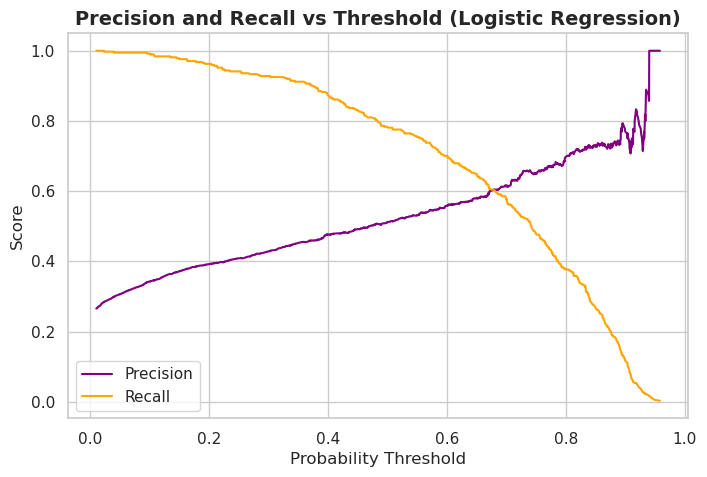

In [15]:
# Plot Precision-Recall vs Threshold 
plt.figure(figsize=(8,5))
plt.plot(thresholds_pr, precision[:-1], label='Precision', color='purple')
plt.plot(thresholds_pr, recall[:-1], label='Recall', color='orange')

plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title(f'Precision and Recall vs Threshold ({best_model_title})', fontweight=TITLE_FONT_WEIGHT, fontsize=TITLE_FONT_SIZE)
plt.legend()
plt.grid(True)
plt.show()


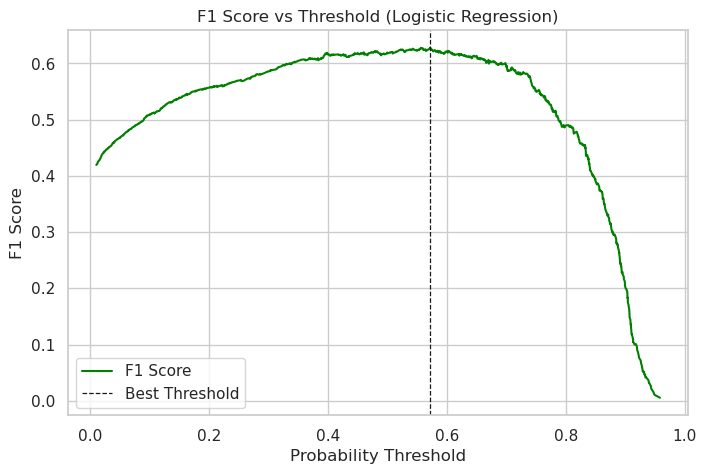

Best Threshold: 0.572
Best F1 Score: 0.628


In [16]:
# Compute F1 for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Find threshold that maximizes F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_idx]
best_f1 = f1_scores[best_idx]

# Save thrshold for future predictions
y_pred_custom = (y_probs >= best_threshold).astype(int)

# Plot F1 Score vs Threshold 
plt.figure(figsize=(8,5))
plt.plot(thresholds_pr, f1_scores, label='F1 Score', color='green')
plt.axvline(x=best_threshold, label='Best Threshold', linewidth=0.9, linestyle='--', color='k')
plt.xlabel('Probability Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()

# Display best threshold and score
print(f'Best Threshold: {best_threshold:.3f}\nBest F1 Score: {best_f1:.3f}')

#### Threshold Optimization Results

- The precision–recall curves show a clear trade-off:

- Lower thresholds increase recall (capturing more churners) but reduce precision.
- Higher thresholds improve precision but miss many actual churners.

- The F1-score curve indicates that the optimal balance between precision and recall occurs at a threshold of approximately 0.572, which exceeds the default value of 0.5.

- For churn prediction, maximizing F1 is often reasonable when both false positives and false negatives carry business costs. Using this optimized threshold can improve the model’s ability to detect churners while maintaining a manageable level of false positives.

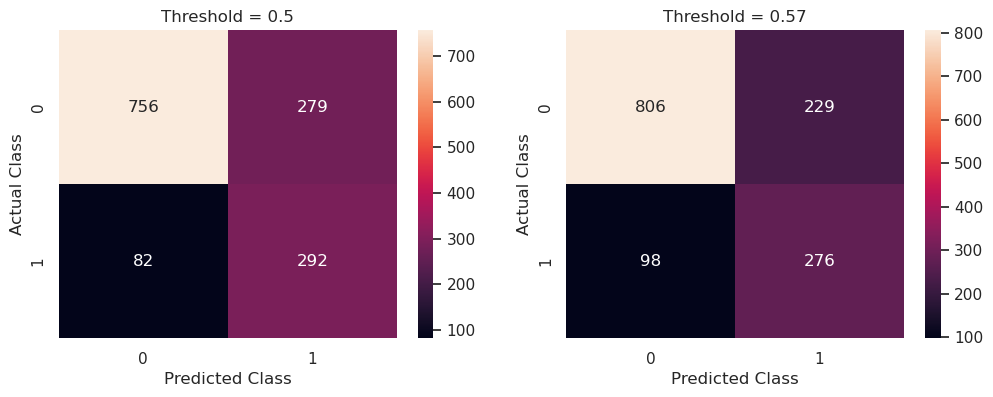

In [17]:
# Store confusion matrix results for each threshold
best_conmat = confusion_matrix(y_test, y_pred_custom)
default_conmat = confusion_matrix(y_test, (y_probs >= 0.5).astype(int))

# Display confusion matrices to compare default vs "best" threshold
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Display default threshold confusion matrix
sns.heatmap(default_conmat, ax=axes[0], annot=True, fmt='1')
axes[0].set_xlabel('Predicted Class')
axes[0].set_ylabel('Actual Class')
axes[0].set_title('Threshold = 0.5')

# Display "best" threshold confusion matrix
sns.heatmap(best_conmat, ax=axes[1], annot=True, fmt='1')
axes[1].set_xlabel('Predicted Class')
axes[1].set_ylabel('Actual Class')
axes[1].set_title(f'Threshold = {best_threshold:.2f}')

plt.show()

**Observations:** Optimizing the classification threshold based on the F1 score improved overall model performance. Compared to the default threshold of 0.5, the optimized threshold correctly classified 50 additional non-churners, at the cost of misclassifying 16 additional churners.

Whether this trade-off is acceptable depends on the relative business cost of false positives versus false negatives. F1 score was used to select the threshold because it balances precision and recall, which is appropriate when both false positives and false negatives have meaningful costs. If retention efforts are costly or limited, reducing false positives may be preferable. Conversely, if missing a potential churner is expensive, a more recall-focused threshold may be warranted.

### 4.2.1 Model Interpretability with SHAP <a class="anchor" id="421-model-interpretability-with-shap"></a>

To better understand how the Logistic Regression model makes churn predictions, we use SHAP (SHapley Additive exPlanations), a model-agnostic interpretability framework.

SHAP values quantify the contribution of each feature to individual predictions and provide both global (dataset-level) and local (customer-level) explanations. This is especially important for churn modeling, where actionable insights often matter as much as predictive performance.

In this section, we compute SHAP values using a background sample of the training data and visualize both the overall feature importance and the directionality of feature effects.

In [18]:
# Sample background data for SHAP 
background = X_train.sample(50) # Small sample size to save time

# Define prediction function for SHAP
def predict_fn(x):
    # SHAP will convert the object to an array
    # Convert it back to a DataFrame 
    x_df = pd.DataFrame(x, columns=X_train.columns)
    return best_model.predict_proba(x_df)[:, 1]

# Build SHAP explainer
explainer = shap.KernelExplainer(predict_fn, background)

# Compute SHAP values for a sample of test data
X_shap = X_test.sample(75) # Small sample to save time
shap_values = explainer.shap_values(X_shap)

  0%|          | 0/75 [00:00<?, ?it/s]

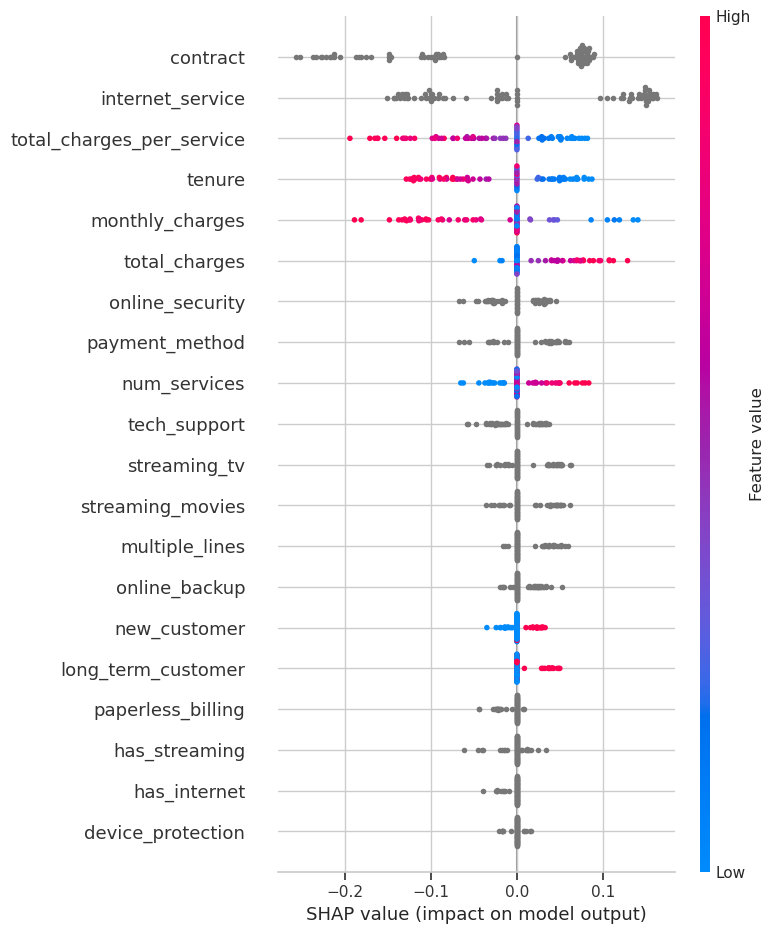

In [19]:
# Create summary "beeswarm" plot
shap.summary_plot(shap_values, X_shap, plot_type='dot')

> Note: Gray points in the SHAP summary plot correspond to observations where the feature value does not vary meaningfully (e.g., binary or one-hot encoded features), making a color gradient less informative.

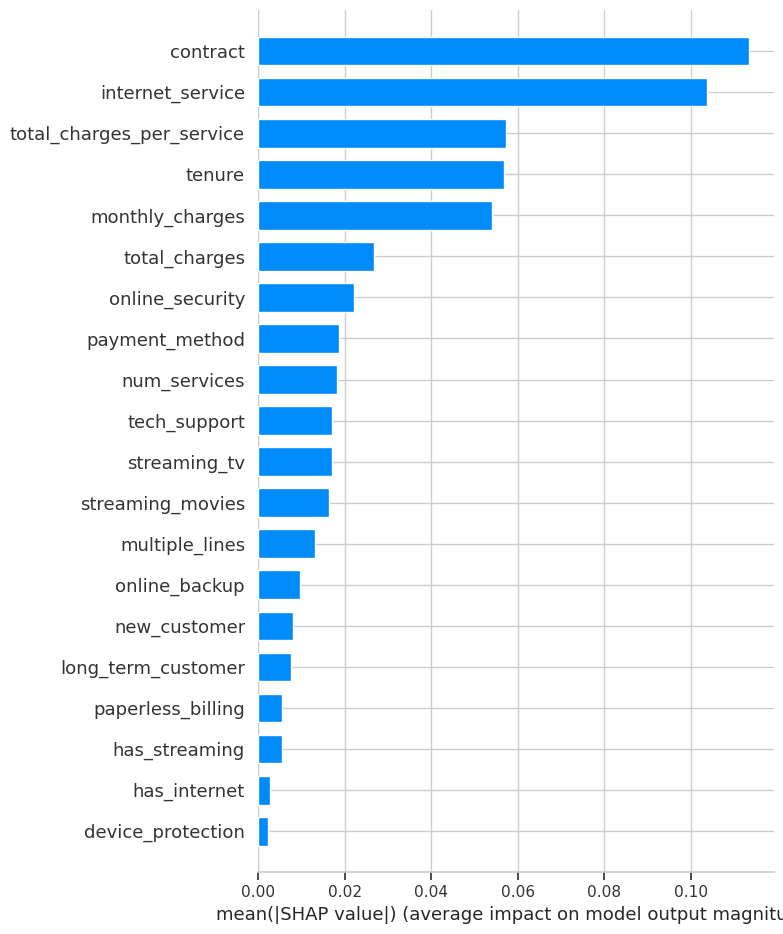

Exception ignored in: <function ResourceTracker.__del__ at 0x7ac2eeb925c0>
Traceback (most recent call last):
  File "/home/thomas/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/thomas/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/thomas/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x70a78dd8e5c0>
Traceback (most recent call last):
  File "/home/thomas/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/thomas/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/thomas/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

In [20]:
# Create summary bar plot
shap.summary_plot(shap_values, X_shap, plot_type='bar')

#### SHAP Interpretation 

- The SHAP summary plots highlight the features that most strongly influence the model’s churn predictions.

- The bar plot reveals that features related to internet service, contract type, tenure, total charges per service, monthly charges, and online service add-ons are among the most influential predictors of churn.

- Service-related features (e.g., online security, tech support) also contribute meaningfully, suggesting that customers without protective services are more likely to leave.

**Directionality of Effects:**
Internet service type (Fiber optic, DSL, or no internet) emerged as one of the strongest predictors of churn. This feature captures distinct customer segments with very different churn behaviors - Fiber optic customers show elevated churn risk, whereas DSL and customers without internet service tend to be more stable. Because the feature expands into multiple one-hot encoded variables, its combined contribution to predictive performance appears even higher than contract type.

These insights align with common retention patterns in the telecom industry and provide a valuable foundation for the business recommendations in the next notebook.

## 4.3 Modeling Summary <a class="anchor" id="43-modeling-summary"></a>

#### 1. Model Selection and Performance

Three classification models were evaluated on the Telco Churn dataset using stratified 5-fold cross-validation:


|**Model**          | **CV ROC-AUC** | **CV PR-AUC** |
|-------------------|------------|-----------|
|Logistic Regression|	0.846    |  0.663    |
|Gradient Boosting  |	0.845    | 	0.655    |
|Random Forest      |	0.824    |	0.615    |

- Logistic Regression achieved the best balance of predictive performance and interpretability, with consistently high ROC-AUC and PR-AUC scores across folds.

- Gradient Boosting and Random Forest performed slightly worse on average, with Random Forest showing higher variability in PR-AUC.

####  2. Threshold Optimization

The default 0.5 probability threshold does not always maximize business-relevant performance.

- Precision–Recall and F1 vs Threshold analysis identified an optimal threshold (~0.572) that balances capturing churners (recall) with avoiding false positives (precision).

- Using this threshold improves the model’s practical effectiveness for retention campaigns, but is worse at detecting churners overall - a tradeoff which depends on the costs of misclassification.

> **Key insight:** Adjusting the threshold tailors predictions to business priorities, which is especially important in imbalanced datasets like churn.

#### 3. Model Interpretability with SHAP

SHAP (SHapley Additive Explanations) was used to quantify feature contributions and understand the drivers of churn:

**Global Insights:**

 - Internet service type (Fiber optic, DSL, No Internet) emerged as the strongest predictor. Supporting what we learned in the EDA, Fiber optic customers broadly had much higher churn rates, while DSL and customers  and those without internet were more stable.

 - Contract type, tenure, total charges per service, and monthly charges are also highly influential. Month-to-month contracts and high monthly charges increase churn probability, whereas longer tenure decreases it.

 - Service add-ons (online security, tech support, backup) contribute meaningfully, confirming findings from the exploratory data analysis.

- **Local Insights:**

 - SHAP enables customer-level explanations, highlighting which features most influence the churn prediction for an individual customer. This is valuable for targeting personalized retention efforts.

> **Key insight:** SHAP confirms that the model is learning meaningful, interpretable patterns that align with business knowledge, allowing actionable insights beyond raw predictions.

#### 4. Summary Takeaways

1. Logistic Regression is the best-performing model considering both performance and interpretability.

2. F1 Threshold optimization improves overall performance, but with the cost of catching fewer churners.

3. SHAP analysis validates that the model is using meaningful, business-relevant features, providing confidence in both global trends and individual-level predictions.